# Realtime ASR

Let say you want to transcribe realtime recording / input, malaya-speech able to do that.

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/realtime-asr](https://github.com/huseinzol05/malaya-speech/tree/master/example/realtime-asr).
    
</div>

<div class="alert alert-warning">

This module is not language independent, so it not save to use on different languages. Pretrained models trained on hyperlocal languages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
import malaya_speech
from malaya_speech import Pipeline

### Load VAD model

We are going to use quantized vggvox-v2 VAD model.

In [2]:
vad_model = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)

### Recording interface

So, to start recording audio including realtime VAD and ASR, we need to use `malaya_speech.streaming.record`. We use `pyaudio` library as the backend.

```python
def record(
    vad,
    asr_model = None,
    device = None,
    input_rate: int = 16000,
    sample_rate: int = 16000,
    min_length: float = 0.1,
    filename: str = None,
    spinner: bool = True,
):
    """
    Record an audio using pyaudio library. This record interface required a VAD model.

    Parameters
    ----------
    vad: object
        vad model / pipeline.
    asr_model: object
        ASR model / pipeline, will transcribe each subsamples realtime.
    device: None
        `device` parameter for pyaudio.
    input_rate: int, optional (default = 16000)
        sample rate from input device, this will auto resampling.
    sample_rate: int, optional (default = 16000)
        output sample rate.
    min_length: float, optional (default=0.1)
        minimum length (s) to accept a subsample.
    filename: str, optional (default=None)
        if None, will auto generate name based on timestamp.
    spinner: bool, optional (default=True)
        if True, will use spinner object from halo library.


    Returns
    -------
    result : [filename, samples]
    """
```

**pyaudio will returned int16 bytes, so we need to change to numpy array, normalize it to -1 and +1 floating point**.

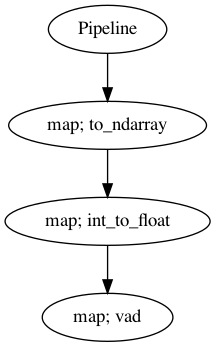

In [3]:
p = Pipeline()
pipeline = (
    p.map(malaya_speech.astype.to_ndarray)
    .map(malaya_speech.astype.int_to_float)
    .map(vad_model)
)
p.visualize()

### Load ASR model

In [4]:
quantized_model = malaya_speech.stt.deep_ctc(model = 'quartznet', quantized = True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


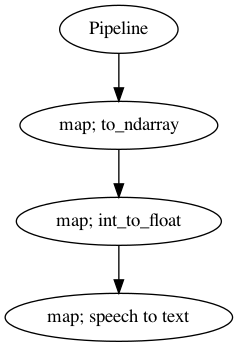

In [5]:
p_asr = Pipeline()
pipeline_asr = (
    p_asr.map(malaya_speech.astype.to_ndarray)
    .map(malaya_speech.astype.int_to_float)
    .map(quantized_model)
)
p_asr.visualize()

**Again, once you start to run the code below, it will straight away recording your voice**. 

If you run in jupyter notebook, press button stop up there to stop recording, if in terminal, press `CTRL + c`.

In [6]:
file, samples = malaya_speech.streaming.record(vad = p, asr_model = p_asr, spinner = False)
file

Listening (ctrl-C to stop recording) ... 



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=320
  n_fft, y.shape[-1]


Sample 0 2020-11-28 13:45:16.207900: ela
Sample 1 2020-11-28 13:45:20.147814: nak saya nak makan
Sample 2 2020-11-28 13:45:20.961547: ayam
Sample 3 2020-11-28 13:45:24.735462: ayam masak pedas
Sample 4 2020-11-28 13:45:28.130483: semoga sedaplah
Sample 5 2020-11-28 13:45:30.300991: an
Sample 6 2020-11-28 13:45:33.825635: yan
Sample 7 2020-11-28 13:45:37.271249: saya rasi bini saya busuk hari ini
Sample 8 2020-11-28 13:45:39.204503: aham
Sample 9 2020-11-28 13:45:43.264181: katu kenapa dia busuk
Sample 10 2020-11-28 13:45:45.821596: tukan
saved audio to savewav_2020-11-28_13-45-47_082882.wav


'savewav_2020-11-28_13-45-47_082882.wav'

As you can see, it able to transcribe realtime, you can try it by yourself.

In [9]:
len(samples[0])

2

In [10]:
type(samples[0][0]), samples[0][1]

(bytearray, 'ela')

I do not want to print `samples[0][0]`, it is very long.